In [328]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import datetime
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

In [329]:
def read_csv_dataset(file_name):
    df = pd.read_csv(file_name)
    print('Formato do dataset: ',df.shape)
    print('Feature Engineering...')
    date_split = df['Month'].str.split('-').str
    df['Year'], df['Month'] = date_split
    m = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12, }
    df['Month'] = df['Month'].map(m)
    df.drop(df.columns[[3,4,5,6]], axis=1, inplace=True) #vou só ficar com as colunas 0,1,2,6
    df.drop(df.tail(2).index,inplace=True) #eliminar as duas últimas linhas com lixo
    df.dropna() #just to be sure
    df["Year"] = df["Year"].astype(dtype=np.float64) #converter coluna do ano para floats
    print('Formato do dataset: ',df.shape)
    print(df.head())
    return df

In [330]:
#função load_data do lstm.py configurada para aceitar qualquer número de parametros
#o último atributo é que fica como label (resultado)
#stock é um dataframe do pandas (uma especie de dicionario + matriz)
#seq_len é o tamanho da janela a ser utilizada na serie temporal
def load_data(df_dados, janela):
    #print(df_dados)
    qt_atributos = len(df_dados.columns)
    tam_sequencia = janela + 1
    #converter dataframe para matriz (lista com lista de cada registo) fazendo a divisão já em dados de teste e treino
    train_matrix =  df_dados.iloc[:24].as_matrix()
    test_matrix = df_dados.iloc[24:].as_matrix()
    
    #processamento dados de treino de acordo com o tamanho da janela
    train = []
    for i in range(len(train_matrix) - tam_sequencia): #numero de registos - tamanho da sequencia
        train.append(train_matrix[i: i + tam_sequencia])
    train = np.array(train) #dá como resultado um np com uma lista de matrizes (janela deslizante ao longo da serie)
    #print(train.shape)
    
    #processamento dados de test de acordo com o tamanho da janela
    test = []
    for i in range(len(test_matrix) - tam_sequencia):
        test.append(test_matrix[i: i + tam_sequencia])
    test = np.array(test)
    #print(test.shape)
    
    
    
    x_train = train[:, :-1] #menos um registo pois o ultimo registo é o registo a seguir à janela
    y_train = train[:, -1][:,2] #para ir buscar o atributo referente às sales para a lista dos labels
    x_test = test[:, :-1]
    y_test = test[:, -1][:,2]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], qt_atributos))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], qt_atributos))
   # print("TRAIN",train)
   # print("TEST",test)
   # print("X_TRAIN",x_train)
   # print("Y_TRAIN",y_train)
   # print("X_TEST",x_test)
   # print("Y_TEST",y_test)
    return [x_train,y_train,x_test,y_test]
   

In [331]:
# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar '''
def build_model2(janela):
    model = Sequential()
    model.add(LSTM(128, input_shape=(janela, 4), return_sequences=True))
    model.add(Dropout(0.7))
    model.add(LSTM(64, input_shape=(janela, 4), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32, input_shape=(janela, 4), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [332]:
def print_model(model,fich):
 from keras.utils import plot_model
 plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

In [333]:
#imprime um grafico com os valores de teste e com as correspondentes tabela de previsões
def print_series_prediction(y_test,predic):
    diff=[]
    racio=[]
    for i in range(len(y_test)): #para imprimir tabela de previsoes
        racio.append( (y_test[i]/predic[i])-1)
        diff.append( abs(y_test[i]- predic[i]))
        print('valor: %f ---> Previsão: %f Diff: %f Racio: %f' % (y_test[i],predic[i], diff[i],racio[i]))
    plt.plot(y_test,color='blue', label='y_test')
    plt.plot(predic,color='red', label='prediction') #este deu uma linha em branco
    plt.plot(diff,color='green', label='diff')
    plt.plot(racio,color='yellow', label='racio')
    plt.legend(loc='upper left')
    plt.show()

In [334]:
def normalization (df):
    
    min_max_scaler = MinMaxScaler()
    scaled_features = min_max_scaler.fit_transform(df)
    df = pd.DataFrame(scaled_features,columns=df.columns)
    return df

In [335]:
def pre_processing (df):
    
    df['Month'] = df['Month'] / 100
    df['Advertising'] = df['Advertising'] / 100
    df['Sales'] = df['Sales'] / 100
    df['Year'] = df['Year'] / 100

    return df

In [336]:
def LSTM_():
    df = read_csv_dataset("advertising-and-sales-data-36-co.csv")
    df = pre_processing(df)
    print("df", df.shape)
    print(df.head())
    janela = 2 #tamanho da Janela deslizante
    #X_train, y_train, X_test, y_test = load_data(df[::-1], janela)# o df[::-1] é o df por ordem inversa
    X_train, y_train, X_test, y_test = load_data(df, janela)# o ler o def por ordem normal
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    print("X_test", X_test.shape)
    print("y_test", y_test.shape)
    model = build_model2(janela)
    model.fit(X_train, y_train, batch_size=512, epochs=200, validation_split=0.1, verbose=1)
    #print_model(model,"lstm_model.png")
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    print(model.metrics_names)
    p = model.predict(X_test)
    predic = np.squeeze(np.asarray(p)) #para transformar uma matriz de uma coluna e n linhas em um np array de n elementos
    print_series_prediction(y_test,predic)
    # MSE- (Mean square error), RMSE- (root mean square error) - 
    # o significado de RMSE depende do range da label. para o mesmo range menor é melhor.

Formato do dataset:  (38, 7)
Feature Engineering...
Formato do dataset:  (36, 4)
   Month  Advertising  Sales  Year
0    1.0         12.0   15.0   1.0
1    2.0         20.5   16.0   1.0
2    3.0         21.0   18.0   1.0
3    4.0         15.5   27.0   1.0
4    5.0         15.3   21.0   1.0
df (36, 4)
   Month  Advertising  Sales  Year
0   0.01        0.120   0.15  0.01
1   0.02        0.205   0.16  0.01
2   0.03        0.210   0.18  0.01
3   0.04        0.155   0.27  0.01
4   0.05        0.153   0.21  0.01
X_train (21, 2, 4)
y_train (21,)
X_test (9, 2, 4)
y_test (9,)


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


Train on 18 samples, validate on 3 samples
Epoch 1/200
18/18 [==============================] - 34s 2s/step - loss: 0.1492 - acc: 0.0000e+00 - val_loss: 0.0397 - val_acc: 0.0000e+00
Epoch 2/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1483 - acc: 0.0000e+00 - val_loss: 0.0392 - val_acc: 0.0000e+00
Epoch 3/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1475 - acc: 0.0000e+00 - val_loss: 0.0388 - val_acc: 0.0000e+00
Epoch 4/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1467 - acc: 0.0000e+00 - val_loss: 0.0383 - val_acc: 0.0000e+00
Epoch 5/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1458 - acc: 0.0000e+00 - val_loss: 0.0378 - val_acc: 0.0000e+00
Epoch 6/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1449 - acc: 0.0000e+00 - val_loss: 0.0373 - val_acc: 0.0000e+00
Epoch 7/200
18/18 [==============================] - 0s 2ms/step - loss: 0.1440 - acc: 0.0000e+00 - val_loss: 0.0368 - val_

Epoch 60/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0327 - acc: 0.0000e+00 - val_loss: 0.0445 - val_acc: 0.0000e+00
Epoch 61/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0283 - acc: 0.0000e+00 - val_loss: 0.0392 - val_acc: 0.0000e+00
Epoch 62/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0296 - acc: 0.0000e+00 - val_loss: 0.0344 - val_acc: 0.0000e+00
Epoch 63/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0265 - acc: 0.0000e+00 - val_loss: 0.0304 - val_acc: 0.0000e+00
Epoch 64/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0286 - acc: 0.0000e+00 - val_loss: 0.0272 - val_acc: 0.0000e+00
Epoch 65/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0241 - acc: 0.0000e+00 - val_loss: 0.0248 - val_acc: 0.0000e+00
Epoch 66/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0253 - acc: 0.0000e+00 - val_loss: 0.0231 - val_acc: 0.0000e+00
Epoch 67/200
18/18 [

Epoch 119/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0237 - acc: 0.0000e+00 - val_loss: 0.0338 - val_acc: 0.0000e+00
Epoch 120/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0220 - acc: 0.0000e+00 - val_loss: 0.0333 - val_acc: 0.0000e+00
Epoch 121/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0229 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 122/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0218 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 123/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0240 - acc: 0.0000e+00 - val_loss: 0.0333 - val_acc: 0.0000e+00
Epoch 124/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0237 - acc: 0.0000e+00 - val_loss: 0.0335 - val_acc: 0.0000e+00
Epoch 125/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0300 - acc: 0.0000e+00 - val_loss: 0.0339 - val_acc: 0.0000e+00
Epoch 126/200

Epoch 178/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0277 - acc: 0.0000e+00 - val_loss: 0.0339 - val_acc: 0.0000e+00
Epoch 179/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0254 - acc: 0.0000e+00 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 180/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0292 - acc: 0.0000e+00 - val_loss: 0.0336 - val_acc: 0.0000e+00
Epoch 181/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0292 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 182/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0248 - acc: 0.0000e+00 - val_loss: 0.0329 - val_acc: 0.0000e+00
Epoch 183/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0265 - acc: 0.0000e+00 - val_loss: 0.0329 - val_acc: 0.0000e+00
Epoch 184/200
18/18 [==============================] - 0s 2ms/step - loss: 0.0236 - acc: 0.0000e+00 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 185/200

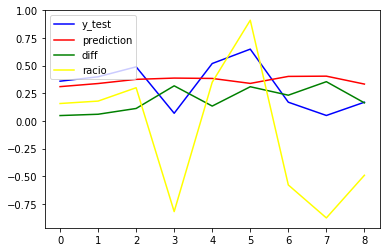

In [337]:
if __name__ == '__main__':
 #visualize_GOOGL()
 LSTM_()
 
 